In [1]:
from scipy.misc import imsave
import numpy as np
from tqdm import tqdm
from LoadLightField import *
from LightFieldFunctions import *
from SaveLightField import *
from DepthFunctions import *

mydir = "../WorkingData/Synthetic/"
name = "Synthetic"

In [2]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(mydir)

In [3]:
syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\antinous\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\boardgames\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\dishes\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\kitchen\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\pens\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\rosemary\\"
#syn_dir = "D:\\David\\LightFieldData\\Synthetic\\additional\\tower\\"

21


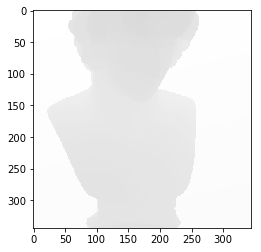

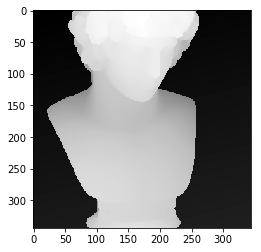

In [15]:
lightfield = loadSyntheticLF(syn_dir, gantry=True)
depth = loadSyntheticDepth(syn_dir, gantry=True)
disp = loadSyntheticDisparity(syn_dir, gantry=True)

plotDepth(depth)
plotDisp(disp)

loaddir = "../WorkingData/"
filename = loaddir + "general_37_eslf.png"
meta = loaddir + "general_37.json"
lightfield = loadESLF(filename,meta)

print(lightfield.shape)

depth_name = loaddir + "general_37_warp_depth.png"
depth_meta = loaddir + "general_37_warp_depth.jsn"

depth = loadDepth(depth_name,depth_meta)

plotDepth(depth)

(344L, 344L, 3L)


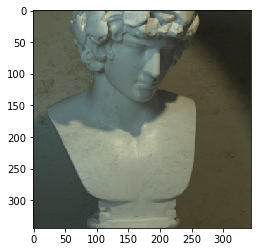

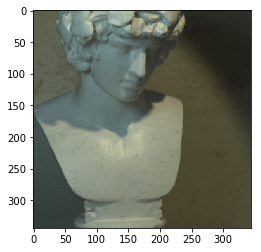

In [8]:
center = getView(lightfield,0,0)
right = getView(lightfield,0,1)

print(center.shape)

plt.imshow(center);plt.show()
plt.imshow(right);plt.show()

In [16]:
from scipy.interpolate import RectBivariateSpline
from tqdm import tqdm, trange


def calibrateDisp(disp, left, right, split = .90, num_iters = 100, sd=0.5):
    
    rows, cols, ch = right.shape
    
    # Generate interpolated field
    x, y = np.array(range(cols)),np.array(range(rows))
    ipR = RectBivariateSpline(y, x, right[:,:,0], kx=1, ky=1)
    ipG = RectBivariateSpline(y, x, right[:,:,1], kx=1, ky=1)
    ipB = RectBivariateSpline(y, x, right[:,:,2], kx=1, ky=1)   
    
    xv, yv = np.meshgrid(x,y)
    trials = {}
    k=1.0
    
    for n in trange(num_iters):
                
        d = k*disp
        eR = ipR(yv,xv-d,grid=False)-left[:,:,0]
        eG = ipG(yv,xv-d,grid=False)-left[:,:,1]
        eB = ipB(yv,xv-d,grid=False)-left[:,:,2]
            
        errors = (np.multiply(eR,eR) + np.multiply(eG,eG) + np.multiply(eB,eB)).flatten()

        errors.sort()
        
        # Only take elements in the first 90%
        errors = errors[:int(split*len(errors))]
        
        # Keep the total error
        trials[k]= (sum(errors))
        
        # Randomize k about the assumed depth
        k = np.random.lognormal(0,sd)
        
        
    best_k = 0
    best_error = 1000000
    
    for k, error in trials.items():
        if error < best_error:
            best_k = k
            best_error = error
            
    return best_k        

# Depth Calibration
#disp = 1/depth

k = calibrateDisp(disp, center, right)

100%|████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.36it/s]


In [17]:
#k=1; epsilon=.6
epsilon = 1.4
print(k,epsilon)

(1.0, 1.4)


In [18]:
from cv2 import erode, dilate, blur
def processMask(mask, erosions = 1, dilations = 1, blurs = 1 ):
    
    kernel = np.ones((3,3))
    
    # Remember: We want to open the black squares
    for _ in range(erosions):
        mask = erode(mask,kernel)
    
    for _ in range(dilations):
        mask = dilate(mask,kernel)
            
    # Soften Boundary
    for _ in range(blurs):
        mask = blur(mask, (3,3))
        
    return mask

In [19]:
#Save the center image
imsave(mydir+name+"_0_0_image.png",center)

In [22]:
for i in range(-1,2):
    for j in trange(-1,2):
        if i == 0 and j == 0:
            continue
            
        current = getView(lightfield,i,j)
        
        rows, cols, ch = current.shape

        # Generate interpolated field
        x, y = np.array(range(cols)),np.array(range(rows))
        xv, yv = np.meshgrid(x,y)

        mask = np.zeros((rows,cols))

        disp_x = j*k*disp
        disp_y = i*k*disp

        dx_max = int(np.ceil(np.amax(np.abs(disp_x))))*np.sign(j)
        dy_max = int(np.ceil(np.amax(np.abs(disp_y))))*np.sign(i)
        
        #print(dx_max, dy_max)
        
        xmap = xv-disp_x # Right view locations
        ymap = yv-disp_y

        dx = np.zeros((rows,cols))
        dy = np.zeros((rows,cols))       

        mask = np.ones((rows,cols))

        # Make new view disparity map
        for xR in x:
            for yR in y:
                
                if j < 0:
                    xvals = range(max(xR+dx_max,0),xR+1)
                if j == 0:
                    xvals = [xR]
                if j > 0:
                    xvals = range(xR,min(xR+dx_max,cols))
                
                if i < 0:
                    yvals = range(max(yR+dy_max,0),yR+1)
                if i == 0:
                    yvals = [yR]
                if i > 0:
                    yvals = range(yR,min(yR+dy_max,rows))
                
                #print(xvals)
                #print(yvals)
                
                window_x = xmap[:,xvals][yvals,:] - xR # Left View Location
                window_dx = disp_x[:,xvals][yvals,:]
                window_y = ymap[:,xvals][yvals,:] - yR
                window_dy = disp_y[:,xvals][yvals,:]

                #print(window_x)
                #print(window_dx)
                
                indices = np.where((np.square(window_x)+np.square(window_y)<epsilon))

                # Account for 0 to 1 mappings and many to one mappings
                if indices[0].size:
                    possibles = np.square(window_dx[indices]) + np.square(window_dy[indices])
                    index = np.argmax(possibles)
                    dx[yR,xR] = window_dx[indices][index]
                    dy[yR,xR] = window_dy[indices][index]
                else:
                    mask[yR,xR] = 0

        # Post Process mask
        #mask = processMask(mask, 2, 1, 2)
        
        # Save outputs
        imsave(mydir + name + "_" +str(i) +"_" + str(j)+"_image.png",current)
        imsave(mydir + name + "_" +str(i) +"_" + str(j)+"_mask.png",mask)
        imsave(mydir + name + "_" +str(i) +"_" + str(j)+"_dx.png",dx)
        imsave(mydir + name + "_" +str(i) +"_" + str(j)+"_dy.png",dy)
        np.save(mydir + name + "_" +str(i) +"_" + str(j)+"_mask",mask)
        np.save(mydir + name + "_" +str(i) +"_" + str(j)+"_dx",dx)
        np.save(mydir + name + "_" +str(i) +"_" + str(j)+"_dy",dy)

print("Done!")

100%|████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.91s/it]


Done!
